X–θ test on NIST processed_compressed build.hdf5

We define a candidate hidden phase θ (either from settings-holonomy or from a trial clock), bin trials by θ, compute an Eberhard-style J per bin, and use a drift-preserving permutation test to see if modulation is real or an artifact.


In [ ]:
import os, math, json
from dataclasses import dataclass
from typing import Dict, Any, Tuple

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
@dataclass
class CFG:
    URL: str = (
        "https://s3.amazonaws.com/nist-belltestdata/belldata/processed_compressed/hdf5/2015_09_18/"
        "03_31_CH_pockel_100kHz.run4.afterTimingfix2_training.dat.compressed.build.hdf5"
    )
    HDF5_PATH: str = "./data_nist/nist_run.build.hdf5"

    START: int = 0
    MAX_TRIALS: int = 3_000_000  # None for full file (heavy)

    # theta modes:
    # 1) "turning_angle_settings_path" = holonomy of settings-history (global memory hypothesis)
    # 2) "index_phase" = theta_n = 2π (n mod P)/P  (per-trial clock hypothesis)
    THETA_MODE: str = "turning_angle_settings_path"
    PERIOD_P: int = 4096  # used only for index_phase

    THETA_BINS: int = 12
    THETA_WRAP_2PI: bool = True

    BLOCK_SIZE: int = 20_000
    PERM_ROUNDS: int = 200
    SEED: int = 123

    MIN_VALID_PER_BIN: int = 20_000


CFG = CFG()
os.makedirs(os.path.dirname(CFG.HDF5_PATH), exist_ok=True)
print("Using HDF5_PATH:", CFG.HDF5_PATH)


def download_with_resume(url: str, out_path: str, chunk_size: int = 8 * 1024 * 1024):
    import requests

    headers = {}
    mode = "wb"
    if os.path.exists(out_path):
        existing = os.path.getsize(out_path)
        headers["Range"] = f"bytes={existing}-"
        mode = "ab"
        print(f"Resuming at byte {existing:,}")
    else:
        print("Starting fresh download")

    with requests.get(url, stream=True, headers=headers, timeout=60) as r:
        r.raise_for_status()
        with open(out_path, mode) as f:
            for chunk in r.iter_content(chunk_size=chunk_size):
                if chunk:
                    f.write(chunk)


if not os.path.exists(CFG.HDF5_PATH):
    download_with_resume(CFG.URL, CFG.HDF5_PATH)
else:
    print("File exists, skipping download.")

Using HDF5_PATH: ./data_nist/nist_run.build.hdf5
Starting fresh download


settings are often stored as {1,2}. We remap the two most common values → {0,1}.


In [ ]:
def list_hdf5_datasets(hdf5_path: str) -> pd.DataFrame:
    rows = []
    with h5py.File(hdf5_path, "r") as h5:

        def walk(name, obj):
            if isinstance(obj, h5py.Dataset):
                shape = tuple(obj.shape)
                ndim = len(shape)
                n0 = int(shape[0]) if ndim >= 1 else 1
                rows.append(
                    {
                        "path": name,
                        "shape": shape,
                        "dtype": str(obj.dtype),
                        "ndim": ndim,
                        "n0": n0,
                    }
                )

        h5.visititems(walk)
    df = (
        pd.DataFrame(rows)
        .sort_values(["ndim", "n0"], ascending=[True, False])
        .reset_index(drop=True)
    )
    df["path_l"] = df["path"].str.lower()
    return df


def read_scalar(h5: h5py.File, path: str) -> int:
    return int(np.array(h5[path]))


def remap_two_state_to_01(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x)
    vals, cnt = np.unique(x, return_counts=True)
    order = np.argsort(cnt)[::-1]
    if len(order) < 2:
        return np.full_like(x, -1, dtype=np.int8)
    v0, v1 = vals[order[0]], vals[order[1]]
    out = np.full(x.shape, -1, dtype=np.int8)
    out[x == v0] = 0
    out[x == v1] = 1
    return out

Load aligned streams (this fixes your broadcast error)

alice/settings and bob/settings can differ by a few entries.

clicks length can be different from settings length.

Use offsets/firstsync/{alice,bob} to align settings to the click stream; then truncate to common length.


In [12]:
def load_aligned_trial_streams(hdf5_path: str, start: int, max_trials: int | None):
    with h5py.File(hdf5_path, "r") as h5:
        a0 = (
            read_scalar(h5, "offsets/firstsync/alice")
            if "offsets/firstsync/alice" in h5
            else 0
        )
        b0 = (
            read_scalar(h5, "offsets/firstsync/bob")
            if "offsets/firstsync/bob" in h5
            else 0
        )

        a_click = h5["alice/clicks"][:]
        b_click = h5["bob/clicks"][:]
        N_click = min(len(a_click), len(b_click))

        a_set_raw = h5["alice/settings"][a0 : a0 + N_click]
        b_set_raw = h5["bob/settings"][b0 : b0 + N_click]

    a_set = remap_two_state_to_01(a_set_raw)
    b_set = remap_two_state_to_01(b_set_raw)

    ok = (a_set >= 0) & (b_set >= 0)
    a_set = a_set[ok].astype(np.int8)
    b_set = b_set[ok].astype(np.int8)

    # ok is defined on aligned length N_click
    a_click = a_click[: len(ok)][ok]
    b_click = b_click[: len(ok)][ok]

    N = len(a_set)
    end = N if max_trials is None else min(N, start + max_trials)
    sl = slice(start, end)

    return a_set[sl], b_set[sl], a_click[sl], b_click[sl]


df_ds = list_hdf5_datasets(CFG.HDF5_PATH)
display(df_ds)

a_set, b_set, a_click, b_click = load_aligned_trial_streams(
    CFG.HDF5_PATH, CFG.START, CFG.MAX_TRIALS
)
print("Loaded N:", len(a_set))
print("a unique:", np.unique(a_set), "b unique:", np.unique(b_set))
print("click nonzero frac:", float((a_click != 0).mean()), float((b_click != 0).mean()))

,path,shape,dtype,ndim,n0,path_l
0,config/alice/bitoffset,(),int64,0,1,config/alice/bitoffset
1,config/alice/pk,(),int64,0,1,config/alice/pk
2,config/alice/radius,(),int64,0,1,config/alice/radius
3,config/bob/bitoffset,(),int64,0,1,config/bob/bitoffset
4,config/bob/pk,(),int64,0,1,config/bob/pk
5,config/bob/radius,(),int64,0,1,config/bob/radius
6,alice/settings,"(28526907,)",uint8,1,28526907,alice/settings
7,bob/settings,"(28526894,)",uint8,1,28526894,bob/settings
8,alice/clicks,"(363,)",uint16,1,363,alice/clicks
9,bob/clicks,"(363,)",uint16,1,363,bob/clicks


Loaded N: 363
a unique: [0 1] b unique: [0 1]
click nonzero frac: 0.0 0.0


Outcomes

With these build files, the simplest “trialized” outcome is:
A=1 iff alice/clicks != 0, else A=0 (same for B).
(This matches what you already computed: low detection rate is expected.)


In [ ]:
A_det = (a_click != 0).astype(np.int8)
B_det = (b_click != 0).astype(np.int8)

print("Alice detection rate:", float(A_det.mean()))
print("Bob detection rate:", float(B_det.mean()))
print("Coincidence rate:", float((A_det & B_det).mean()))
print("Both-miss rate:", float(((1 - A_det) & (1 - B_det)).mean()))

# Popcount (fixes int.bit_count numpy error)
POPCOUNT16 = (
    np.unpackbits(np.arange(65536, dtype=np.uint16).view(np.uint8))
    .reshape(65536, 16)
    .sum(axis=1)
    .astype(np.uint8)
)
pcA = POPCOUNT16[a_click.astype(np.uint16)]
pcB = POPCOUNT16[b_click.astype(np.uint16)]
print(
    "A popcount: min/median/p95/max =",
    int(pcA.min()),
    float(np.median(pcA)),
    float(np.percentile(pcA, 95)),
    int(pcA.max()),
)
print(
    "B popcount: min/median/p95/max =",
    int(pcB.min()),
    float(np.median(pcB)),
    float(np.percentile(pcB, 95)),
    int(pcB.max()),
)

Alice detection rate: 0.0
Bob detection rate: 0.0
Coincidence rate: 0.0
Both-miss rate: 1.0
A popcount: min/median/p95/max = 0 0.0 0.0 0
B popcount: min/median/p95/max = 0 0.0 0.0 0


In [ ]:
# ---- Fast lookup: mask -> slot index (0..15), or -1 if no click or multi-click ----
MASK_TO_SLOT = np.full(1 << 16, -1, dtype=np.int8)
for k in range(16):
    MASK_TO_SLOT[1 << k] = k  # exactly one bit set


def decode_slot_from_mask(click_mask: np.ndarray) -> np.ndarray:
    """
    click_mask: uint16 array, typically either 0 (no click) or a single bit.
    returns slot index 0..15, or -1 if no click / ambiguous.
    """
    cm = click_mask.astype(np.uint16, copy=False)
    return MASK_TO_SLOT[cm]


def load_slot_meta(hdf5_path: str) -> Dict[str, int]:
    with h5py.File(hdf5_path, "r") as h5:
        meta = {
            "a_pk": (
                int(np.array(h5["config/alice/pk"])) if "config/alice/pk" in h5 else 0
            ),
            "a_radius": (
                int(np.array(h5["config/alice/radius"]))
                if "config/alice/radius" in h5
                else 0
            ),
            "a_bitoffset": (
                int(np.array(h5["config/alice/bitoffset"]))
                if "config/alice/bitoffset" in h5
                else 0
            ),
            "b_pk": int(np.array(h5["config/bob/pk"])) if "config/bob/pk" in h5 else 0,
            "b_radius": (
                int(np.array(h5["config/bob/radius"]))
                if "config/bob/radius" in h5
                else 0
            ),
            "b_bitoffset": (
                int(np.array(h5["config/bob/bitoffset"]))
                if "config/bob/bitoffset" in h5
                else 0
            ),
        }
    return meta


meta = load_slot_meta(CFG.HDF5_PATH)
print(meta)

{'a_pk': 90, 'a_radius': 4, 'a_bitoffset': 28, 'b_pk': 125, 'b_radius': 5, 'b_bitoffset': 37}


Build θ from slot difference + build ±1 outcomes

θ is defined only when both slots are valid (coincidence trials).

Outcomes A,B are ±1 timing bits, not “click/no click”.


In [ ]:
def mod16(x: np.ndarray) -> np.ndarray:
    return (x.astype(np.int16) % 16).astype(np.int8)


slotA = decode_slot_from_mask(a_click)
slotB = decode_slot_from_mask(b_click)

coinc = (slotA >= 0) & (slotB >= 0)
print("Coincidences:", int(coinc.sum()), "out of", len(slotA))

# theta from slot difference (on the 16-cycle)
dslot = mod16(slotA[coinc] - slotB[coinc])  # 0..15
theta = 2 * np.pi * dslot.astype(np.float64) / 16.0

# timing outcomes: half-cycle relative to pk (0..7 => +1, 8..15 => -1)
relA = mod16(slotA[coinc] - meta["a_pk"])
relB = mod16(slotB[coinc] - meta["b_pk"])

A_pm1 = np.where(relA <= 7, +1, -1).astype(np.int8)
B_pm1 = np.where(relB <= 7, +1, -1).astype(np.int8)

# Keep corresponding settings for these coincidence trials
a_c = a_set[coinc]
b_c = b_set[coinc]

# Bin theta
edges = np.linspace(0, 2 * np.pi, CFG.THETA_BINS + 1)
theta_bin = np.clip(np.digitize(theta, edges) - 1, 0, CFG.THETA_BINS - 1).astype(
    np.int16
)

print("theta bin counts:", np.bincount(theta_bin, minlength=CFG.THETA_BINS))

Coincidences: 0 out of 363
theta bin counts: [0 0 0 0 0 0 0 0 0 0 0 0]


CHSH S for ±1 outcomes on coincidence trials

Compute
𝐸
(
𝑎
,
𝑏
)
=
⟨
𝐴
𝐵
⟩
E(a,b)=⟨AB⟩ and
𝑆
=
𝐸
00

- 𝐸
  01
- 𝐸
  10
  −
  𝐸
  11
  S=E
  00
  ​

  +E
  01
  ​

  +E
  10
  ​

−E
11
​

.


Baseline S (coincidence timing-outcome): nan
Counts: {(0, 0): 0, (0, 1): 0, (1, 0): 0, (1, 1): 0}


,bin,n,theta_center,S
0,0,0,0.261799,NaN
1,1,0,0.785398,NaN
2,2,0,1.308997,NaN
3,3,0,1.832596,NaN
4,4,0,2.356194,NaN
5,5,0,2.879793,NaN
6,6,0,3.403392,NaN
7,7,0,3.926991,NaN
8,8,0,4.450590,NaN
9,9,0,4.974188,NaN


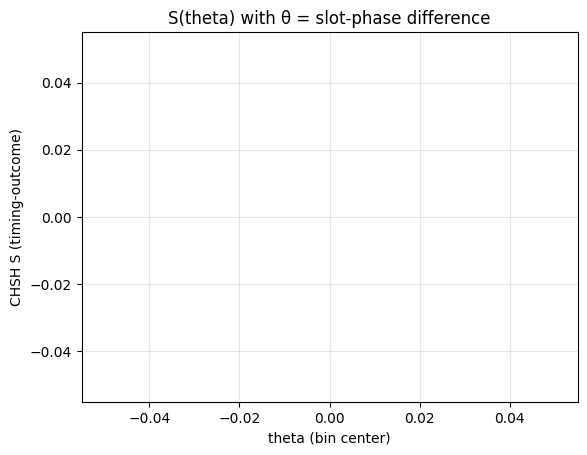

In [ ]:
def chsh_S_pm1(a_set, b_set, A_pm1, B_pm1, signs=(+1, +1, +1, -1)) -> Dict[str, Any]:
    E = {}
    N = {}
    AB = (A_pm1.astype(np.int16) * B_pm1.astype(np.int16)).astype(np.int16)
    for a in (0, 1):
        for b in (0, 1):
            m = (a_set == a) & (b_set == b)
            n = int(m.sum())
            N[(a, b)] = n
            E[(a, b)] = float(np.mean(AB[m])) if n > 0 else np.nan
    s00, s01, s10, s11 = signs
    S = s00 * E[(0, 0)] + s01 * E[(0, 1)] + s10 * E[(1, 0)] + s11 * E[(1, 1)]
    return {"E": E, "N": N, "S": float(S)}


def binned_S_theta(
    a_set, b_set, A_pm1, B_pm1, theta_bin, bins: int, min_per_bin: int
) -> pd.DataFrame:
    edges = np.linspace(0, 2 * np.pi, bins + 1)
    rows = []
    for k in range(bins):
        m = theta_bin == k
        n = int(m.sum())
        theta_center = float(0.5 * (edges[k] + edges[k + 1]))
        if n < min_per_bin:
            rows.append({"bin": k, "n": n, "theta_center": theta_center, "S": np.nan})
            continue
        rows.append(
            {
                "bin": k,
                "n": n,
                "theta_center": theta_center,
                "S": chsh_S_pm1(a_set[m], b_set[m], A_pm1[m], B_pm1[m])["S"],
            }
        )
    return pd.DataFrame(rows)


baseline = chsh_S_pm1(a_c, b_c, A_pm1, B_pm1)
print("Baseline S (coincidence timing-outcome):", baseline["S"])
print("Counts:", baseline["N"])

bs = binned_S_theta(
    a_c,
    b_c,
    A_pm1,
    B_pm1,
    theta_bin,
    bins=CFG.THETA_BINS,
    min_per_bin=CFG.MIN_VALID_PER_BIN,
)

display(bs)

plt.figure()
plt.plot(bs["theta_center"], bs["S"], marker="o")
plt.xlabel("theta (bin center)")
plt.ylabel("CHSH S (timing-outcome)")
plt.title("S(theta) with θ = slot-phase difference")
plt.grid(True, alpha=0.3)
plt.show()

θ definitions

turning_angle_settings_path: tests “apparatus holonomy/memory driven by settings history”

index_phase: tests “per-trial clock phase” (no settings dependence)


In [ ]:
CORNER = np.array(
    [[-1.0, -1.0], [-1.0, +1.0], [+1.0, -1.0], [+1.0, +1.0]], dtype=np.float64
)  # (0,0),(0,1),(1,0),(1,1)


def compute_theta_turning(
    a_set: np.ndarray, b_set: np.ndarray, wrap_2pi=True
) -> np.ndarray:
    idx = (a_set.astype(np.int8) << 1) | b_set.astype(np.int8)
    pts = CORNER[idx]

    v1 = pts[1:-1] - pts[:-2]
    v2 = pts[2:] - pts[1:-1]

    n1 = np.linalg.norm(v1, axis=1)
    n2 = np.linalg.norm(v2, axis=1)
    eps = 1e-12
    m = (n1 > eps) & (n2 > eps)

    v1n = np.zeros_like(v1)
    v2n = np.zeros_like(v2)
    v1n[m] = v1[m] / n1[m][:, None]
    v2n[m] = v2[m] / n2[m][:, None]

    cross = v1n[:, 0] * v2n[:, 1] - v1n[:, 1] * v2n[:, 0]
    dot = v1n[:, 0] * v2n[:, 0] + v1n[:, 1] * v2n[:, 1]
    ang = np.arctan2(cross, dot)
    ang[~m] = 0.0

    theta = np.zeros(len(a_set), dtype=np.float64)
    theta[2:] = np.cumsum(ang)
    if wrap_2pi:
        theta = np.mod(theta, 2 * np.pi)
    theta[0] = 0.0
    if len(theta) > 2:
        theta[1] = theta[2]
    return theta


def compute_theta_index_phase(n: int, P: int) -> np.ndarray:
    idx = np.arange(n, dtype=np.int64)
    return 2 * np.pi * (idx % P) / float(P)


if CFG.THETA_MODE == "turning_angle_settings_path":
    theta = compute_theta_turning(a_set, b_set, wrap_2pi=CFG.THETA_WRAP_2PI)
elif CFG.THETA_MODE == "index_phase":
    theta = compute_theta_index_phase(len(a_set), CFG.PERIOD_P)
else:
    raise ValueError("Unknown THETA_MODE")

edges = np.linspace(0, 2 * np.pi, CFG.THETA_BINS + 1)
theta_bin = np.clip(np.digitize(theta, edges) - 1, 0, CFG.THETA_BINS - 1).astype(
    np.int16
)

print("theta min/max:", float(theta.min()), float(theta.max()))
print("theta bin counts:", np.bincount(theta_bin, minlength=CFG.THETA_BINS))

theta min/max: 0.0 6.283185307179585
theta bin counts: [21 54 31 22 50 28 13 45 31 10 39 19]


J, binned_J, and the missing-function fixes
This removes your binned_J() signature problem and makes everything explicit.


Baseline J(slice) = 0.000000000000e+00


,bin,n,theta_center,J,J_sci
0,0,21,0.261799,NaN,NaN
1,1,54,0.785398,NaN,NaN
2,2,31,1.308997,NaN,NaN
3,3,22,1.832596,NaN,NaN
4,4,50,2.356194,NaN,NaN
5,5,28,2.879793,NaN,NaN
6,6,13,3.403392,NaN,NaN
7,7,45,3.926991,NaN,NaN
8,8,31,4.450590,NaN,NaN
9,9,10,4.974188,NaN,NaN


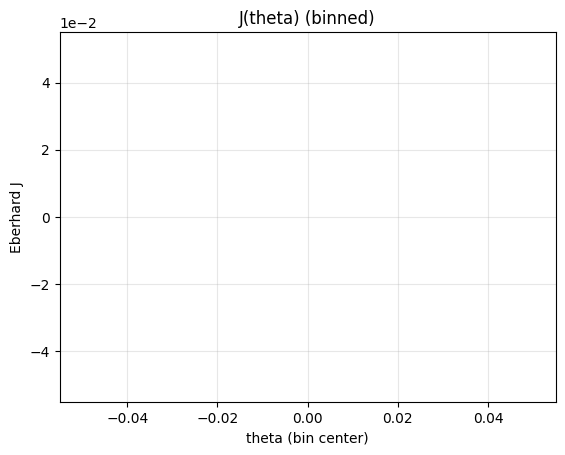

In [ ]:
def eberhard_J(
    a_set: np.ndarray, b_set: np.ndarray, A: np.ndarray, B: np.ndarray
) -> float:
    def probs(a, b):
        m = (a_set == a) & (b_set == b)
        n = int(m.sum())
        if n == 0:
            return (np.nan, np.nan, np.nan)
        Am = A[m]
        Bm = B[m]
        p11 = float(np.mean((Am == 1) & (Bm == 1)))
        p10 = float(np.mean((Am == 1) & (Bm == 0)))
        p01 = float(np.mean((Am == 0) & (Bm == 1)))
        return p11, p10, p01

    p11_00, _, _ = probs(0, 0)
    _, p10_01, _ = probs(0, 1)
    _, _, p01_10 = probs(1, 0)
    p11_11, _, _ = probs(1, 1)

    return float(p11_00 - p10_01 - p01_10 - p11_11)


def binned_J(
    a_set, b_set, A, B, theta_bin, bins: int, min_trials_per_bin: int
) -> pd.DataFrame:
    edges = np.linspace(0, 2 * np.pi, bins + 1)
    rows = []
    for k in range(bins):
        m = theta_bin == k
        n = int(m.sum())
        theta_center = float(0.5 * (edges[k] + edges[k + 1]))
        if n < min_trials_per_bin:
            rows.append({"bin": k, "n": n, "theta_center": theta_center, "J": np.nan})
            continue
        Jk = eberhard_J(a_set[m], b_set[m], A[m], B[m])
        rows.append({"bin": k, "n": n, "theta_center": theta_center, "J": float(Jk)})
    return pd.DataFrame(rows)


J0 = eberhard_J(a_set, b_set, A_det, B_det)
print(f"Baseline J(slice) = {J0:.12e}")

bj = binned_J(
    a_set, b_set, A_det, B_det, theta_bin, CFG.THETA_BINS, CFG.MIN_VALID_PER_BIN
)
display(bj.assign(J_sci=bj["J"].map(lambda v: f"{v:.6e}" if pd.notnull(v) else "NaN")))

plt.figure()
plt.plot(bj["theta_center"], bj["J"], marker="o")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
plt.xlabel("theta (bin center)")
plt.ylabel("Eberhard J")
plt.title("J(theta) (binned)")
plt.grid(True, alpha=0.3)
plt.show()

Δχ² statistic + permutation test (your missing perm_test_delta_chi2)
Permutation is done by shuffling joint outcomes (A,B) within:

time blocks (preserve drift)

each setting pair (preserve setting-conditioned rates)


Permutations: 100%|██████████| 200/200 [00:00<00:00, 1768.16it/s]


Permutation p-value: 0.0
Observed fit: {'delta_chi2': nan, 'c': nan, 'A': nan, 'phi': nan, 'sse_flat': nan, 'sse_sine': nan, 'bins_used': 0}


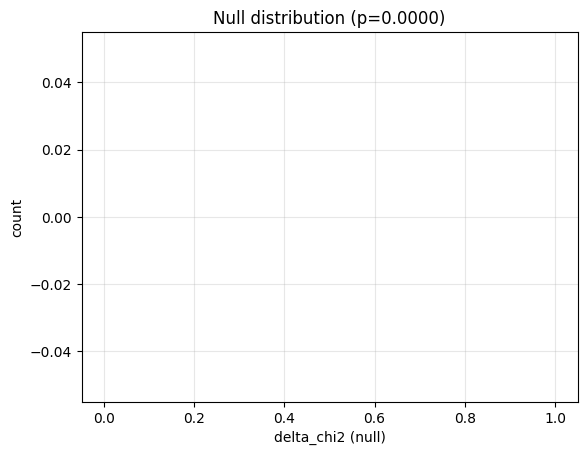

In [ ]:
def fit_delta_chi2(theta_centers: np.ndarray, y: np.ndarray) -> Dict[str, float]:
    ok = np.isfinite(y)
    x = theta_centers[ok]
    y = y[ok]
    if len(y) < 6:
        return {
            "delta_chi2": np.nan,
            "c": np.nan,
            "A": np.nan,
            "phi": np.nan,
            "sse_flat": np.nan,
            "sse_sine": np.nan,
            "bins_used": int(len(y)),
        }

    c0 = float(np.mean(y))
    sse_flat = float(np.sum((y - c0) ** 2))

    X = np.column_stack([np.ones_like(x), np.sin(x), np.cos(x)])
    beta, *_ = np.linalg.lstsq(X, y, rcond=None)
    yhat = X @ beta
    sse_sine = float(np.sum((y - yhat) ** 2))

    c = float(beta[0])
    a = float(beta[1])
    b = float(beta[2])
    Aamp = float(math.sqrt(a * a + b * b))
    phi = float(math.atan2(b, a))

    return {
        "delta_chi2": float(sse_flat - sse_sine),
        "c": c,
        "A": Aamp,
        "phi": phi,
        "sse_flat": sse_flat,
        "sse_sine": sse_sine,
        "bins_used": int(len(y)),
    }


def permute_joint_outcomes_blockwise(
    a_set, b_set, A, B, block_size: int, rng: np.random.Generator
):
    n = len(a_set)
    code = ((A.astype(np.int8) << 1) | B.astype(np.int8)).copy()  # 0..3
    out = code.copy()

    for s in range(0, n, block_size):
        e = min(n, s + block_size)
        sl = slice(s, e)
        for aa in (0, 1):
            for bb in (0, 1):
                m = (a_set[sl] == aa) & (b_set[sl] == bb)
                idx = np.flatnonzero(m) + s
                if len(idx) > 2:
                    out[idx] = rng.permutation(out[idx])

    A_p = ((out >> 1) & 1).astype(np.int8)
    B_p = (out & 1).astype(np.int8)
    return A_p, B_p


def perm_test_delta_chi2(
    a_set,
    b_set,
    A,
    B,
    theta_bin,
    bins,
    block_size,
    perm_rounds,
    min_trials_per_bin,
    seed,
):
    rng = np.random.default_rng(seed)

    bj0 = binned_J(
        a_set, b_set, A, B, theta_bin, bins=bins, min_trials_per_bin=min_trials_per_bin
    )
    obs = fit_delta_chi2(bj0["theta_center"].to_numpy(), bj0["J"].to_numpy())

    null = np.empty(perm_rounds, dtype=np.float64)
    for i in tqdm(range(perm_rounds), desc="Permutations"):
        Ap, Bp = permute_joint_outcomes_blockwise(a_set, b_set, A, B, block_size, rng)
        bjp = binned_J(
            a_set,
            b_set,
            Ap,
            Bp,
            theta_bin,
            bins=bins,
            min_trials_per_bin=min_trials_per_bin,
        )
        null[i] = fit_delta_chi2(bjp["theta_center"].to_numpy(), bjp["J"].to_numpy())[
            "delta_chi2"
        ]

    p = float(np.mean(null >= obs["delta_chi2"]))
    return {"observed": obs, "null_deltas": null, "p_value": p}


pt = perm_test_delta_chi2(
    a_set,
    b_set,
    A_det,
    B_det,
    theta_bin,
    bins=CFG.THETA_BINS,
    block_size=CFG.BLOCK_SIZE,
    perm_rounds=CFG.PERM_ROUNDS,
    min_trials_per_bin=CFG.MIN_VALID_PER_BIN,
    seed=CFG.SEED,
)

print("Permutation p-value:", pt["p_value"])
print("Observed fit:", pt["observed"])

plt.figure()
plt.hist(pt["null_deltas"][np.isfinite(pt["null_deltas"])], bins=30)
plt.axvline(pt["observed"]["delta_chi2"], linewidth=2)
plt.xlabel("delta_chi2 (null)")
plt.ylabel("count")
plt.title(f"Null distribution (p={pt['p_value']:.4f})")
plt.grid(True, alpha=0.3)
plt.show()